# Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.


У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


## Загружаем данные и подготавливаем их к анализу


In [1]:
# импортируем необходимые библиоетки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# открываем файл с визитами и записываем его в переменную visits
visits = pd.read_csv('/datasets/visits_info_short.csv')
# смотрим информацию о таблице
visits.info()
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
# приводим название колонок к нижнему регистру
visits.columns = map(str.lower, visits.columns)
# меняем название некоторых колонок для удобства
visits = visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})
# преобразовываем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
# проверяем
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [4]:
# проверяем таблицу на явные дубликаты
print('Количество явных дубликатов:', visits.duplicated().sum())
# проверяем таблицу на неявные дубликаты
print('Уникальные значения столбца region:', visits['region'].unique())
print('Уникальные значения столбца device:', visits['device'].unique())
print('Уникальные значения столбца channel:', visits['channel'].unique())

# похоже, что все нормально

Количество явных дубликатов: 0
Уникальные значения столбца region: ['United States' 'UK' 'France' 'Germany']
Уникальные значения столбца device: ['iPhone' 'Mac' 'Android' 'PC']
Уникальные значения столбца channel: ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [5]:
# открываем файл с информацией о заказах и записываем его в переменную orders
orders = pd.read_csv('/datasets/orders_info_short.csv')
# смотрим информацию о таблице
orders.info()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
# приводим название колонок к нижнему регистру
orders.columns = map(str.lower, orders.columns)
# меняем назание некоторых колонок
orders = orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'})
# преобразовываем данные о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
# проверяем
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
# открываем файл с информацией о расходах и записываем его в переменную costs
costs = pd.read_csv('/datasets/costs_info_short.csv')
# смотрим информацию о таблице
costs.info()
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [8]:
# приводим название колонок к нижнему регистру
costs.columns = map(str.lower, costs.columns)
# преобразовываем данные о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
# проверяем
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
# проверяем таблицу на наличие явных дубликатов
print('Количество явных дубликатов:', costs.duplicated().sum())
# проверяем столбец channel на наличие неявных дубликатов
print('Уникальные значения столбца channel:', costs['channel'].unique())

# похоже, что все нормально

Количество явных дубликатов: 0
Уникальные значения столбца channel: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


## Задаём функции для расчета и анализа LTV, ROI, удержания и конверсии


In [10]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для расчета удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Проведём исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [18]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(10))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [19]:
# минимальная дата
min_date = profiles['dt'].min()
print('Минимальная дата привлечения пользователей:', min_date)
# максимальная дата (момент анализа)
max_date = profiles['dt'].max()
print('Максимальная дата привлечения пользователей:', max_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


### Анализируем страны, из которых приходят посетители

In [20]:
country_payer = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'})
country_payer['%'] = (country_payer['payer'] / country_payer['user_id'])
country_payer.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
country_payer = country_payer.sort_values(by=['Пользователи'], ascending=False)
country_payer.style.format({'% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


Видно, что посетители приходят из Франции, Германии, Великобритании и Америки. 

Лидирующая позиция у Америки. Из Америки пришло больше всего как обычных, так и платящих пользователей.

### Анализируем устройства, с которых заходят пользователи

In [21]:
device_payer = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'})
device_payer['%'] = (device_payer['payer'] / device_payer['user_id'])
device_payer.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
device_payer = device_payer.sort_values(by=['Пользователи'], ascending=False)
device_payer.style.format({'% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%
Mac,30042,1912,6.36%


По итоговой таблице можем сказать, что пользователи используют Android, Mac, PC и Iphone.

Больше всего люди используют Iphone, как все пользователи - так и платящие.

### Анализируем каналы привлечения пользователей

In [22]:
channel_payer = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'})
channel_payer['%'] = (channel_payer['payer'] / channel_payer['user_id'])
channel_payer.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
channel_payer = channel_payer.sort_values(by=['Пользователи'], ascending=False)
channel_payer.style.format({'% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
channel,,,
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%
WahooNetBanner,8553,453,5.30%
RocketSuperAds,4448,352,7.91%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%


В таблице можно увидеть все каналы привлечения. Большее количество пользователей пришли в приложение самостоятельно, об этом нам указывает канал organic. Однако, платящих пользователей больше всего у канала привлечения FaceBoom.

### Общий вывод


Проанализировав данные, можем сказать, что Америка является лидирующей страной из которой приходят новые пользователи.

Устройство, с которого пользователи больше всего заходят в приложение - это Iphone.

Касаемо канала привлечения - organic является лидирующим среди всех пользователей. Среди платящих пользователей, первое место у канала FaceBoom.

## Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Выясняем, как общая сумма трат распределена по источникам

In [23]:
print('Общая сумма расходов на маркетинг:', profiles['acquisition_cost'].sum())

Общая сумма расходов на маркетинг: 105497.29999999999


In [24]:
total_sum_for_all = profiles.groupby('channel').agg({'acquisition_cost': 'sum'})
total_sum_for_all.columns = ['total_sum']
display(total_sum_for_all.sort_values(by='total_sum', ascending=False))

,total_sum
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


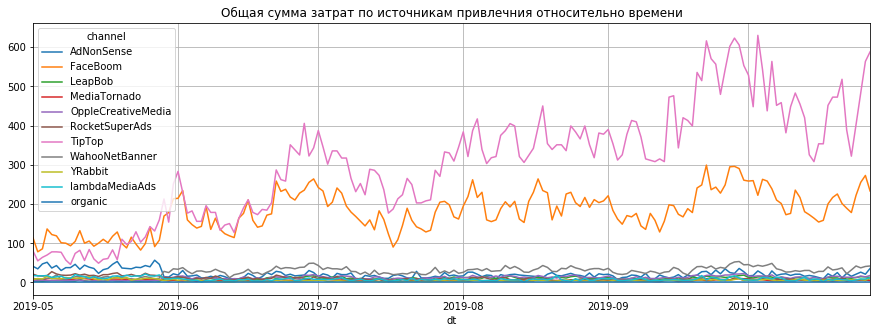

In [25]:
total_cost = profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(
figsize=(15, 5), grid=True, title='Общая сумма затрат по источникам привлечния относительно времени')
plt.show()

На графике видно, что больше всего затрат было по каналу TipTop, от середины исследуемого периода к концу видно - что затраты на маркетинг растут. Но, как показал анализ привлечения пользователей по каналам - TipTop не является лидирующим каналам по притоку новых пользователей.

Следующий канал по затратам на маркетинг - FaceBoom. Здесь затраты ниже, чем у TipTop, но при этом привлеченных пользователей гораздо больше.

### Средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [26]:
profiles = profiles.query('channel != "organic"')
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000


In [27]:
sas_mean = profiles['acquisition_cost'].mean()
print('Средний САС для всего проекта: {:.2}'.format(sas_mean))

Средний САС для всего проекта: 1.1


In [28]:
sas = profiles.groupby('channel').agg({'acquisition_cost': 'mean'})
sas.columns = ['sas']
display(sas.sort_values(by='sas', ascending=False))

,sas
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


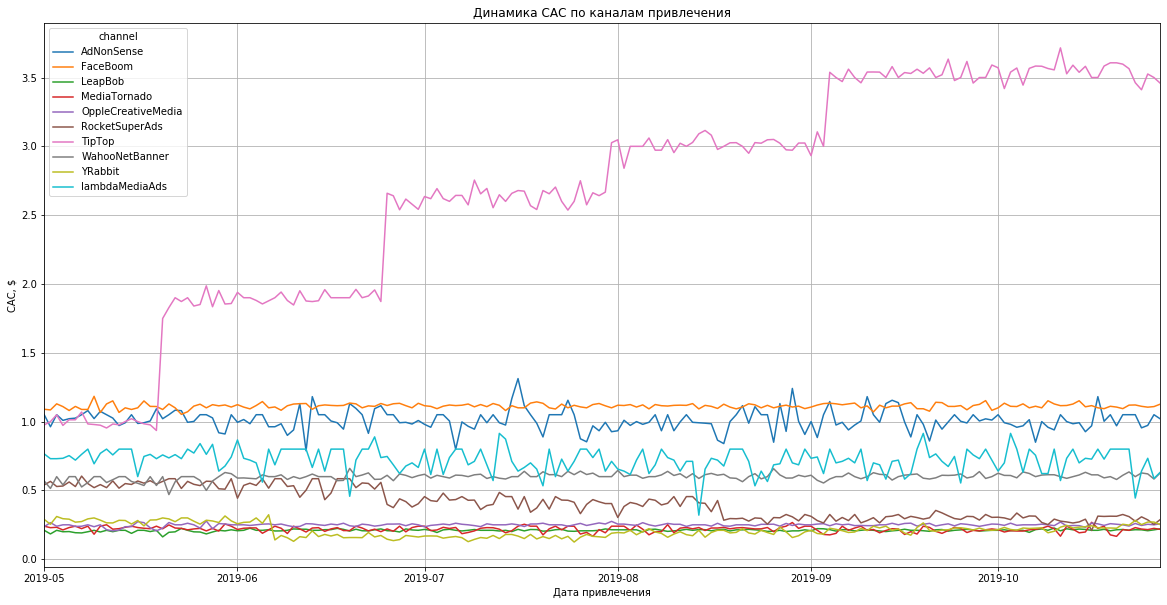

In [29]:
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean').plot(
grid=True, figsize=(20,10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

### Промежуточный вывод

Средний САС для всех пользователей составил 0,7 доллара

При просмотре динамики САС в разбивкой на каналы и даты привлечения можно сказать, что стоимость привлечения выше всего по каналу TipTop, причем стоимость не стабильна - в начале периода она составляет примерно 1-1,5 доллара, и к концу исследуемого периода уже составляет порядка 3,5 доллара

По остальным каналам прослеживается стабильность, стоимость привлечения варьируется от 0,3 до 1,2 доллара
Стоимость органических пользователей равна нулю, так как они перешли в приложение самостоятельно - а не благодаря рекламе.

## Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

In [30]:
# делаем срез данных, убирая пользователей organic
profiles = profiles.query('channel != "organic"')
display(profiles)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
...,...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.900000
150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


In [31]:
# задаем момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

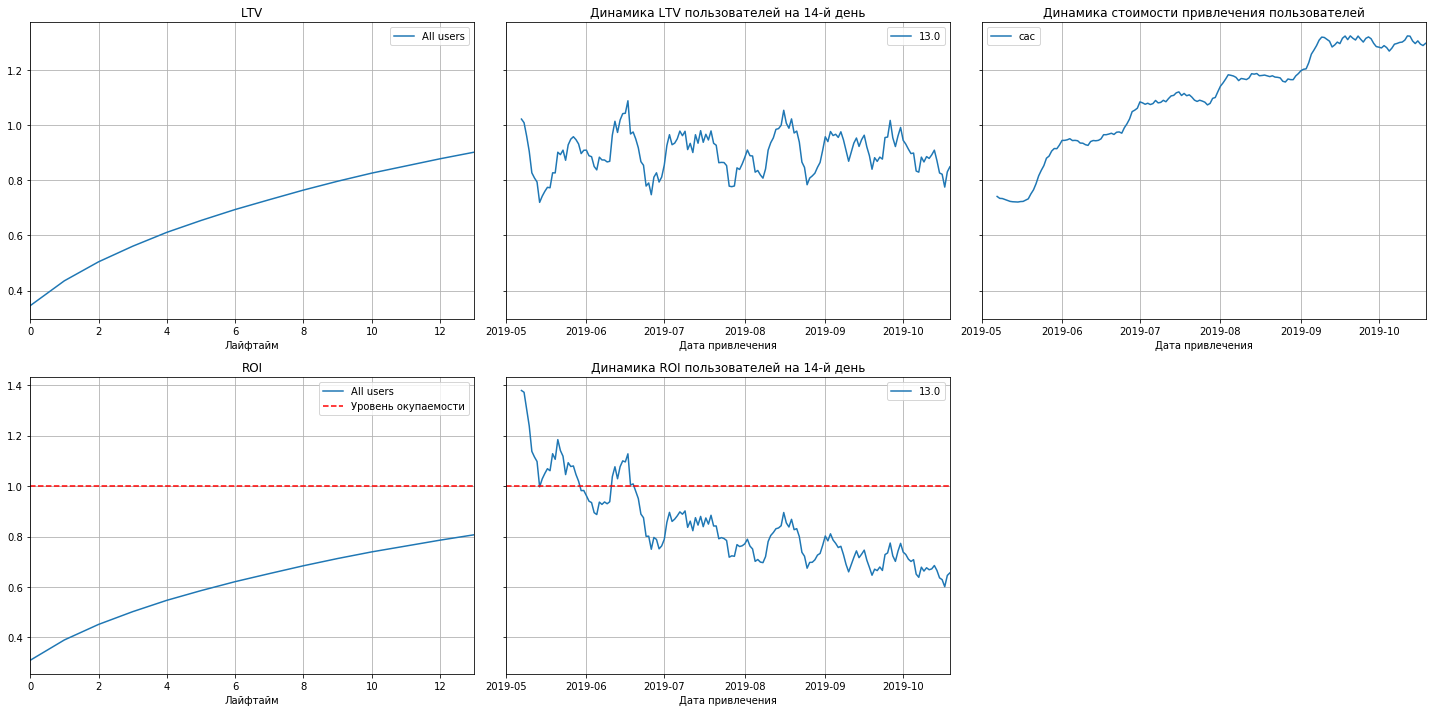

In [32]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

### Промежуточный вывод

По графикам можно сказать, что реклама не окупается. САС не стабилен и постоянно растет. LTV растет и выглядит достаточно стабильным.


### Проанализируйте окупаемость рекламы с разбивкой по устройствам

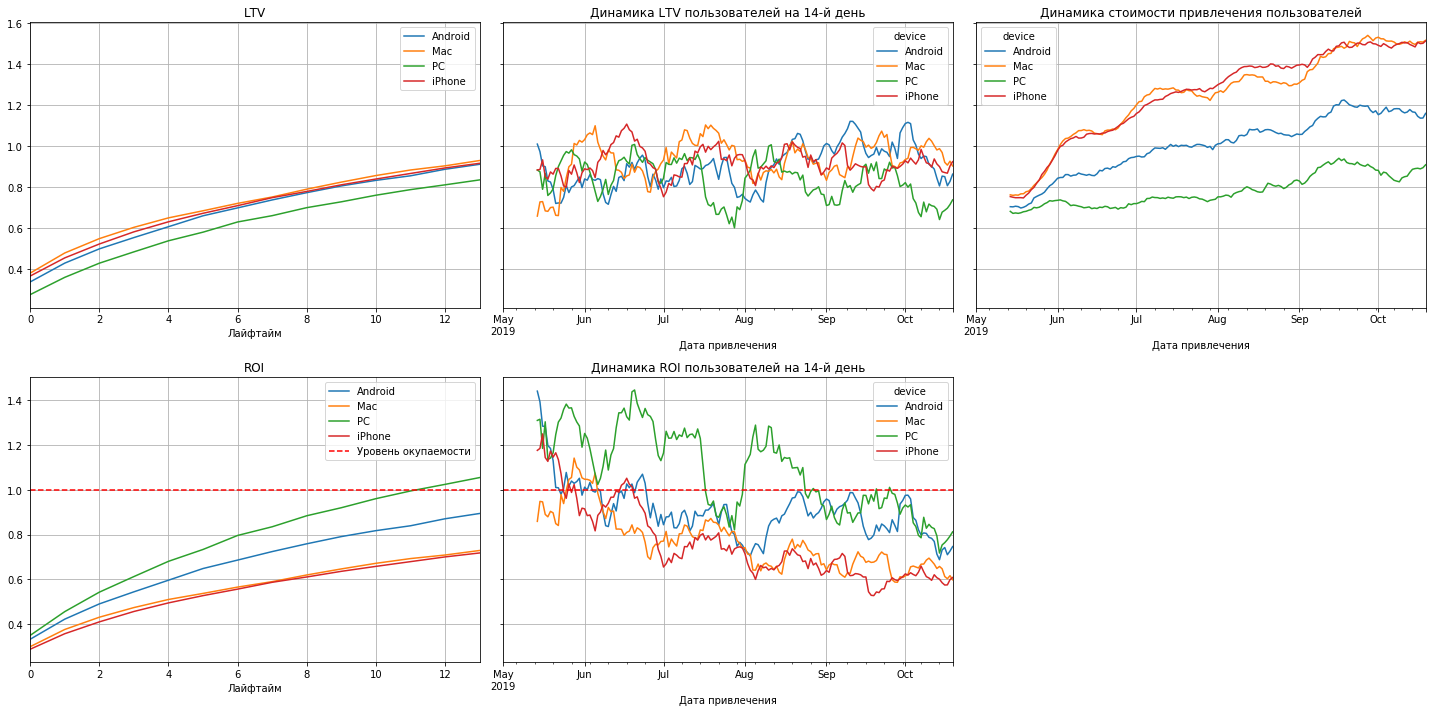

In [33]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### Промежуточный вывод

На графики roi видно, что реклама окупается (с трудом) относительно пользователей, которые заходят с PC. Относительно других устройств реклама не покупается. В целом, cac выглядит достаточно стабильно. Самая высокая стоимость привлечения пользователей Iphone и Mac. На граифке LTV в лидирующих позициях также Iphone и Mac, а вот pc на последнем месте.

### Проанализируйте окупаемость рекламы с разбивкой по странам

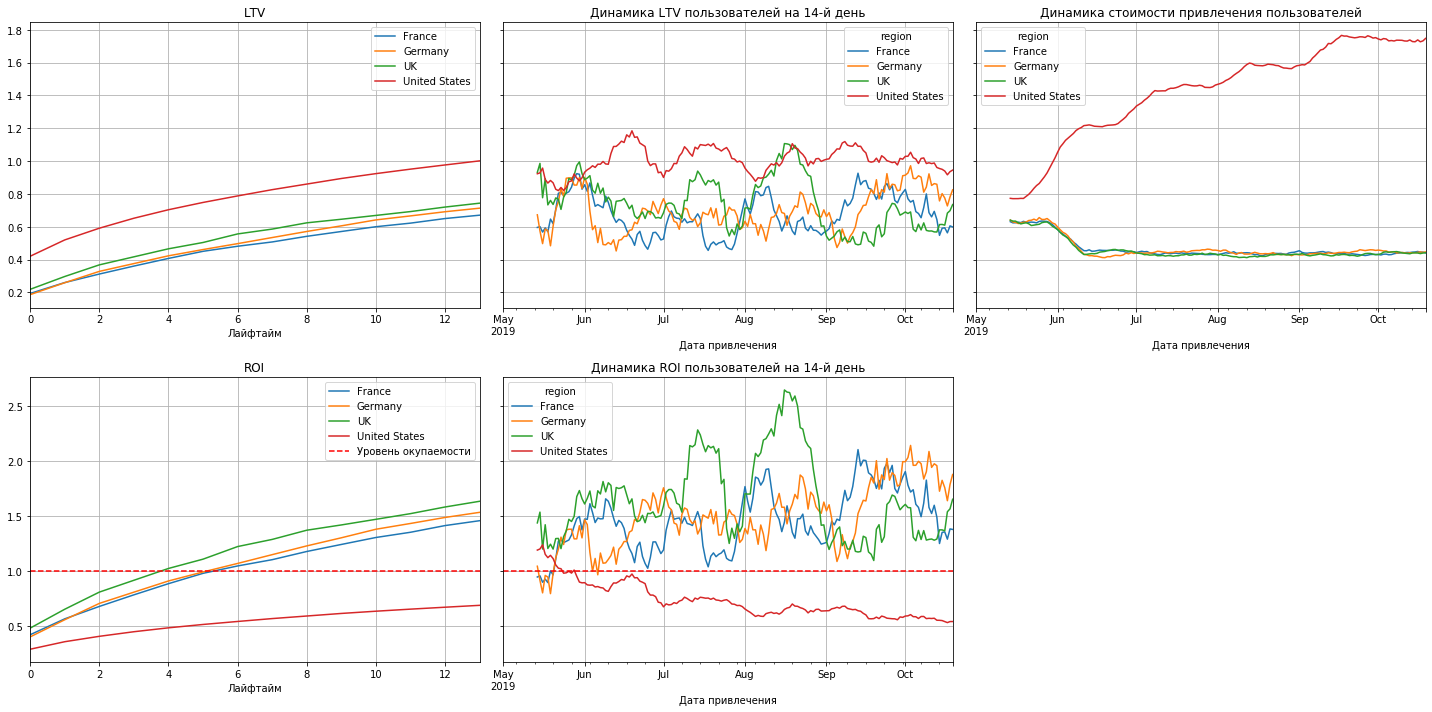

In [34]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### Промежуточный вывод

Интересно, но с разбивкой по странам можно сказать, что реклама достаточно быстро окупается во Франции, Германии и Великобритании, чего не скажешь про Америку - там, судя по графику, реклама не окупается от слова совсем. САС достаточно стабилен относительно Великобритании, Франции и Германии, хоть и в самом начале наблюдается скачок вниз. В Америке САС в динамике показывает, что стоимость привлечения пользователей растет достаточно стремительно. LTV медленно, стабильно ползет наверх, и странно - но Америка показывает наилучший результат 

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

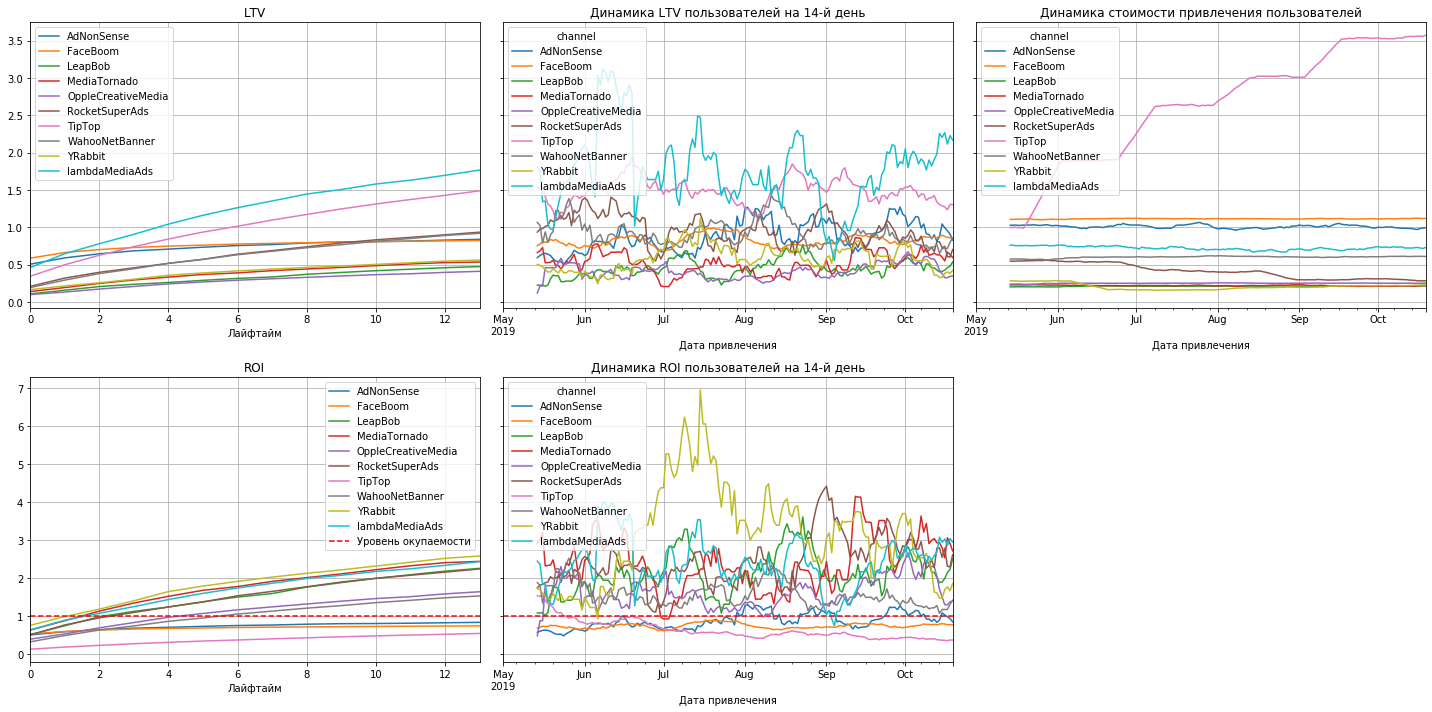

In [35]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### Промежуточный вывод

По графику окупаемости можно сказать, что большая часть каналов окупается - какие-то быстрее, какие-то медленее. Каналы TipTop и FaceBoom не окупаются. САС достаточно стабилен отсносительно всех каналов кроме Tiptop - там наблюдаетсярост стоимости привлечения пользователей. ltv стабильно ползет наверх, больше всего денег приносят пользователи канала LAMBDAMDEIAADS и tiptop

### Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

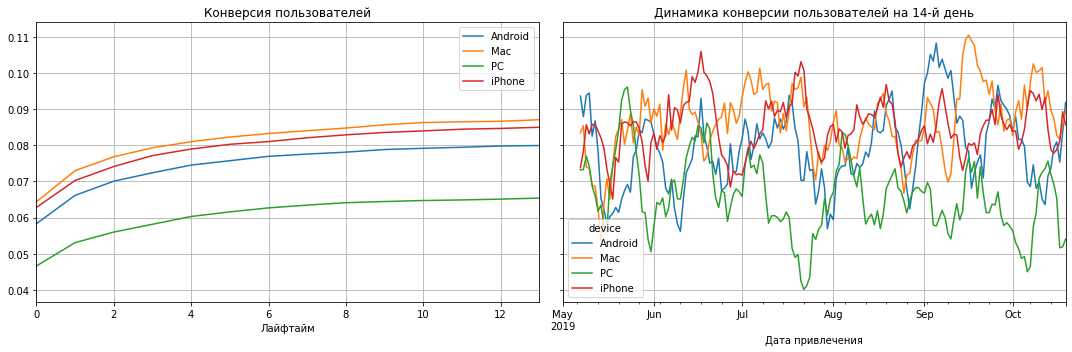

In [36]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

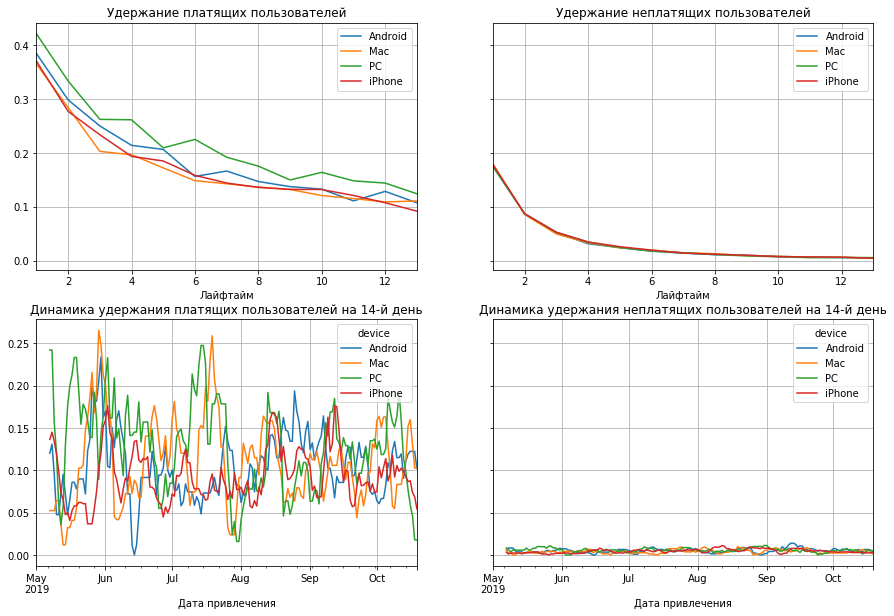

In [37]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Промежуточный вывод

Судя по графикам, пользователи Mac, Iphone и Android конвертируются хорошо, а вот с пользователями pc ситуация немного хуже. 
Если конвертировались устройства +- нормально, то удерживаются пользователи с разбивкой по устройствам не очень хорошо. Возможно, тут присутствует какая-то техническая проблема.

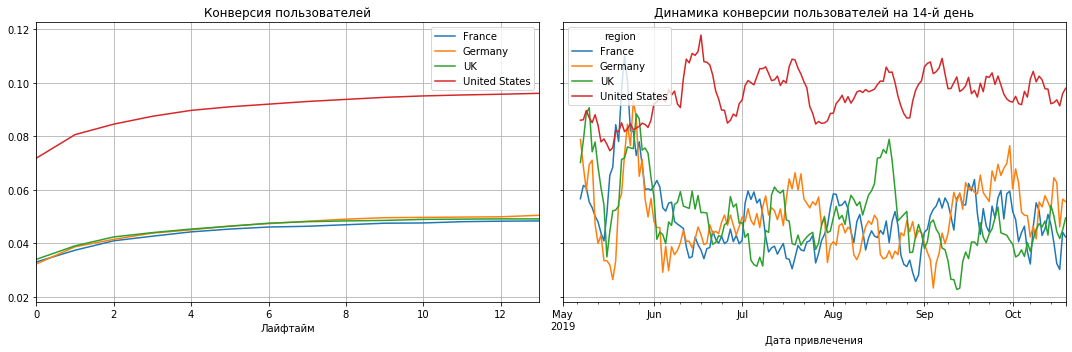

In [38]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

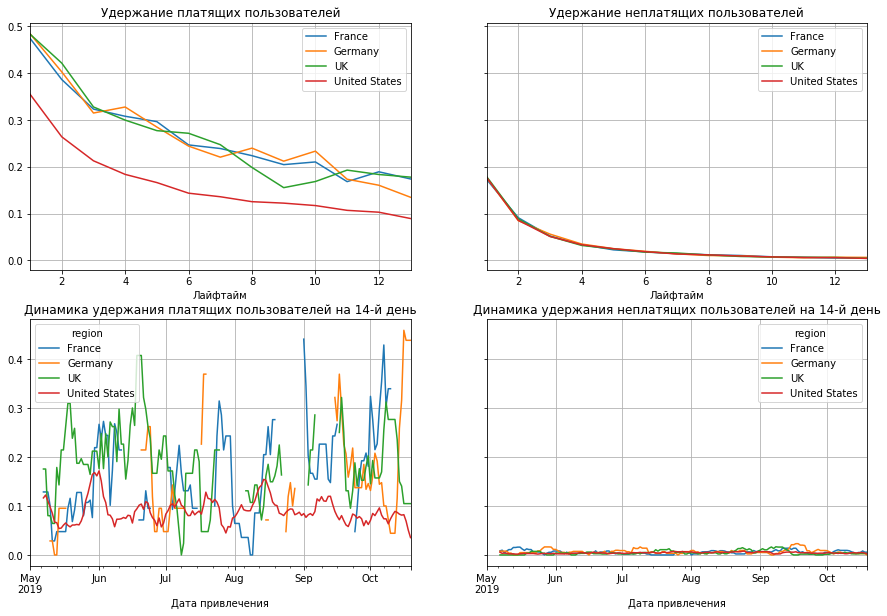

In [39]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Промежуточный вывод

Лучше всего конвертируются пользователи из Америки, причем всё время. А вот удерживаются они хуже всего...

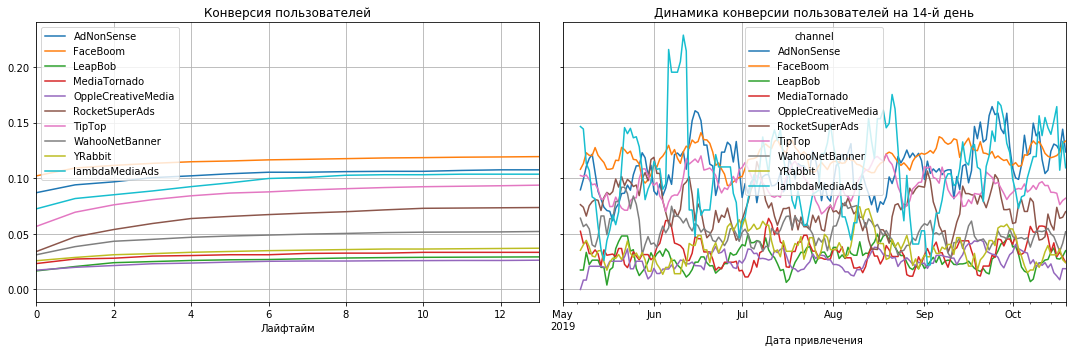

In [40]:
# смотрим конверсию с разбивкой по рекламным каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

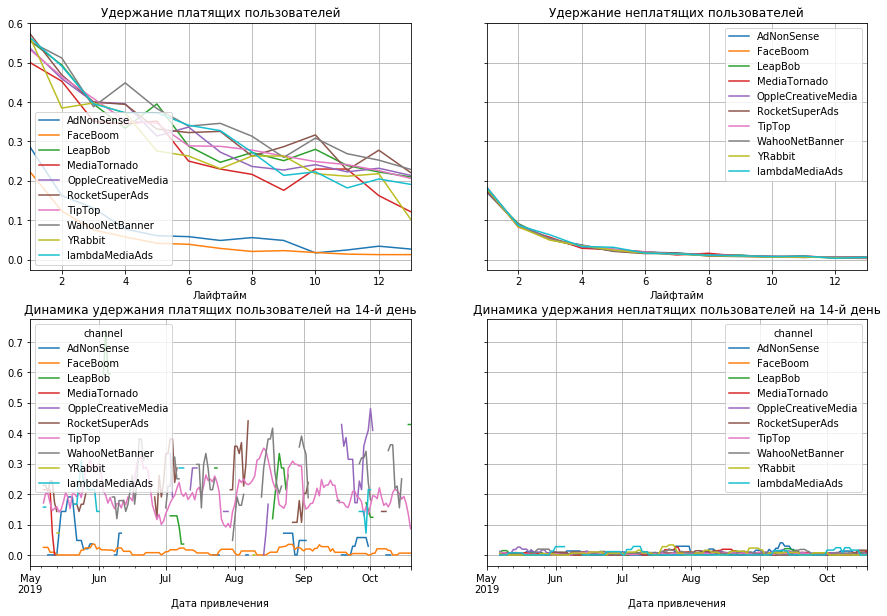

In [41]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Промежуточный вывод

Здесь мы можем сказать, что лучшее всего конвертируются каналы FaceBoom и AdNonSense, при этом удреживаются они хуже всего..


# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Что можно сказать об окупаемости рекламы в целом. По некоторым каналам и странам можно сказать, что реклама окупается. Но в общем и целом - нет. Могу предположить, что Iphone и Mac могут снижать окупаемость рекламы, т.к. затраты на привлечение у них самые высокие - при этом они не окупаются, при этом пользователей с iphone в данных больше всего. Касаемо страны, похоже, что Америка может пагубно влиять на окупаемость рекламы, так как стоимость привлечения самая высокая - но при этом окупаемость отсутствует, НО тем не менее пользователей из Америки в данных больше всего. По каналам привлечения - думаю, что TipTop не самый выгодный канал, так как на привлечение пользователей уходит больше всего денег, а окупаемости нет.

Показатели конверсии для пользователей Mac и Iphone самые высокие, при этом удержание падает для пользователей абсолютно всех устройств. Лучше всего конвертируются пользователи из Америки - но удержиаются они хуже всего. Каналы faceboom и Adnonsense конвертируются лучше всего - при этом у них самое плохое удержание. Так как дополнительных данных нет, и изучить варианты ошибок невозможно - могу предположить, что всё вышесказанное связано с технической проблемой. Возможно Американец с Iphone перешел в приложение через AdNonSense - сделал некоторые манипуляции, после чего оно просто перестало работать (или, как обычно бывает - просто вылетало). Или, возможно, на определенном этапе людям становилось скучно, и они просто удаляли приложение.

Решила исключить из анализа пользоателей канала organic - так как они приходят в приложение сами, а не с помощью рекламы. Думаю, что если их оставить - они немного исказят результаты.

Я бы посоветовала отделу маркетинга обратить внимание на разработку приложения и лучше адаптировать его под разные страны - возможно в этом кроется часть проблемы.
Плюс ко всему этому пересмотреть вложения в рекламу в странах, на устройствах и каналах - в которые вкладывается много денег, при этом отстутсвует окупаемость. В частности я бы посоветовала снизить затраты на привлечение пользователей из Америки. Конечно, это самый большой рынок - но затраты на рекламу неоправданно высоки. 
Ну и хорошо бы было разобраться с чем связано плохое удржание платящих пользователей из Америки и привлеченных пользователей по каналам FaceBoom и AdsNonSence.